### TODO's

- Want a bar graph for the success + failure rates
    - Could be a really straightforward visualization for each product
- QC side: want to be able to categorize what the types of failure are
- Make sure the admin settings are configured + others can view it clearly

In [1]:
# Imports
import boto3
import pandas as pd
import pymysql
import datetime as dt
import aurora_data_api # https://github.com/cloud-utils/aurora-data-api


# Data Visualization/Analysis
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
port = 3306
user = 'admin'
password = 'password'
host1 = 'a1.cluster-cyvmmsfjcmrl.us-east-1.rds.amazonaws.com'
dbName1 = 'db'
resourceARN1 = 'arn:aws:rds:us-east-1:319481862133:cluster:a1'
secretARN1 = 'arn:aws:secretsmanager:us-east-1:319481862133:secret:AuroraQAResults-Rg0Xg1'

In [3]:
# Connection method 1
# client = boto3.client('rds-data')
# response = client.execute_statement(
#     secretArn = secretARN1,
#     database = dbName1,
#     resourceArn = resourceARN1,
#     sql = 'Show Tables'
# )

In [4]:
# Burner Account Credentials
# db = aurora_data_api.connect(aurora_cluster_arn = resourceARN, secret_arn=secretARN, database="db3")
# c = db.cursor()

# Connection method 2
db = aurora_data_api.connect(aurora_cluster_arn = resourceARN1, secret_arn=secretARN1, database=dbName1)
c = db.cursor()

In [5]:
# General helper methods
def getDate():
    return dt.datetime.today().strftime('%Y-%m-%d') # YYYY-MM-DD


# Execute queries + display results
def execute(q):
    c.execute(q) # Execute the query
    return c.fetchall() # Display the output of said query

# 

# Create the initial QA Table
def createQATable():
    q = '''
        Create table if not exists QAResults(
            SerialNumber VARCHAR(30),
            BatchNumber VARCHAR(30),
            Date VARCHAR(10),
            Tester VARCHAR(20),
            FunctionalTest VARCHAR(4),
            FailureType text,
            LogMessage text,
            primary key (SerialNumber)
        )
    '''
    try:
        execute(q)
    except Exception as e:
        print('Issue with table creation:', e)

# Delete the QAResults table
def deleteTable():
    try:
        q = ''' DROP Table QAResults '''
        c.execute(q)
    except Exception as e:
        print('Error with deleting the table:', e)
        
# Helper method to get an entry (based off of SN alone)
def getEntry(sn):
    try:
        q = ''' SELECT * FROM QAResults where SerialNumber = '{}' '''.format(sn)
        #cursor1.execute(q)
        return execute(q)
    except Exception as e:
        print('Issue with get entry:', e)

# Helper method to insert an entry
def insertEntry(sn, bn, ft, tst, msg, fail = None, date = getDate()):
    try:
        q = ''' Insert into QAResults values ('%s', '%s', '%s', '%s', '%s', '%s', '%s')''' % (sn, bn, date, tst, ft, fail, msg)
        return execute(q)
        #executeQuery(q)
    except Exception as e:
        print('Issue with add entry:', e)

# Delete an entry based on SN alone
def deleteEntry(sn):
    try:
        q = ''' Delete from QAResults where SerialNumber = '%s' ''' % (sn)
        #cursor1.execute(q)
        return execute(q)
    except Exception as e:
        print('Issue with delete entry:', e)

# Modify a field based off of SN
def modifyEntry(sn, field, newVal):
    try:
        q = ''' Update QAResults set {} = '{}' where SerialNumber = '{}' '''.format(field, newVal,sn)
        #cursor1.execute(q)
        return execute(q)
    except Exception as e:
        print('Issue with edit entry:', e)

# Get all the results for the table
def displayAll():
    try:
        print('\n\nQAResults Table\n')
        q = ''' Select * From QAResults '''
        display(execute(q))
    except Exception as e:
        print('Issue with displaying table:', e)
        

# Convert into the tabular form... powerful
def convertToDF(tbl):
    try:
        df1 = pd.read_sql('''SELECT * FROM {} '''.format(tbl), con = db)
        return df1
    except Exception as e:
        print('error:', e)

#display(convertToDF('QAResults')) # This is so clean--I love it!

failureTypes = ['None', 'Camera Issue', 'Lighting Issue', 'Night Mode Issue', 'Video Quality Issue', 'Other']

In [6]:
#deleteTable()
createQATable()
insertEntry('EEE833134W-0', 'E2', 'Pass', 'Zach', 'Everything works', failureTypes[0])
insertEntry('EEE833134W-1', 'E2', 'Fail', 'Ruohan','Everything works', failureTypes[1])
insertEntry('EEE833134W-2', 'E2','Fail', 'Ryan','Breakdown occurred', failureTypes[2])
displayAll() # After insertion of entries
modifyEntry('EEE833134W-1', 'BatchNumber', 'F33')
displayAll() # After modification of an entry
deleteEntry('EEE833134W-2')
displayAll() # After deletion of an entry



QAResults Table



[('EEE833134W-0',
  'E2',
  '2021-06-15',
  'Zach',
  'Pass',
  'None',
  'Everything works'),
 ('EEE833134W-1',
  'E2',
  '2021-06-15',
  'Ruohan',
  'Fail',
  'Camera Issue',
  'Everything works'),
 ('EEE833134W-2',
  'E2',
  '2021-06-15',
  'Ryan',
  'Fail',
  'Lighting Issue',
  'Breakdown occurred')]



QAResults Table



[('EEE833134W-0',
  'E2',
  '2021-06-15',
  'Zach',
  'Pass',
  'None',
  'Everything works'),
 ('EEE833134W-1',
  'F33',
  '2021-06-15',
  'Ruohan',
  'Fail',
  'Camera Issue',
  'Everything works'),
 ('EEE833134W-2',
  'E2',
  '2021-06-15',
  'Ryan',
  'Fail',
  'Lighting Issue',
  'Breakdown occurred')]



QAResults Table



[('EEE833134W-0',
  'E2',
  '2021-06-15',
  'Zach',
  'Pass',
  'None',
  'Everything works'),
 ('EEE833134W-1',
  'F33',
  '2021-06-15',
  'Ruohan',
  'Fail',
  'Camera Issue',
  'Everything works')]

In [7]:

# Functions + Variables to mass insert entries (consistently) into the database
snPrefix = ['EUHWQ3931-', 'ABC22', 'RRH43144', '283367144']
batchNums = ['EE1', 'FF2', 'GG3']
testers = ['Zach', 'Ryan', 'Ruohan', 'Nikki', 'Megan']
results = ['Pass', 'Fail']
dates = [getDate(), '2020-05-02', '2020-06-09', '2019-11-27', '2021-04-19', '2021-04-01']
messages = ['Camera is not doing so hot', 'Night mode issue ensued', 'Other issue-unlisted']
passMsg = 'Everything works'

def massInsertEntry(n):
    for i in range(n):
        sn = snPrefix[i % 4] + str(i)
        bn = batchNums[i % 3]
        t = testers[i % 5]
        res = results[int(i % 4 == 0)]
        d = dates[i % 6]
        if res == 'Pass':
            fail = failureTypes[0]
            msg = passMsg
        else:
            fail = failureTypes[i % 3 + 1] if i < 20 else failureTypes[i % 5 + 1] 
            msg = messages[i % 3]
        insertEntry(sn, bn, res, t, msg, fail, d)
massInsertEntry(100)

In [8]:

# Date Queries

# Must obtain an exact match
def getDay(date):
    q = ''' Select * from QAResults where Date = '{}' '''.format(date)
    return execute(q)

# Format: date is passed in as YYYY-MM to be matched against given dates
def getMonth(date):
    q = ''' Select * from QAResults where Substring(Date, 1, 7) = '{}' '''.format(date)
    return execute(q)

# Get all entries for a given year
def getYear(year):
    q = ''' Select * from QAResults where Substring(Date, 1, 4) = '{}' '''.format(year)
    return execute(q)

# Get all entries before a date (inclusive)
def getEntriesBefore(date):
    q = ''' Select * from QAResults where Date < '{}' '''.format(date)
    return execute(q)
    
# Get all entries after a date (inclusive)
def getEntriesAfter(date):
    q = ''' Select * from QAResults where Date >= '{}' '''.format(date)
    return execute(q)

# Get all the entries that fall b/w a specific start and end date
def getEntriesBetween(start, end):
    q = ''' Select * from QAResults where Date <= '{}' and Date >= '{}' '''.format(end, start)
    return execute(q)

In [9]:

# Testing date framework
def testDateFunctions():
    day = '2021-04-19'
    month = '2021-06'
    year = '2019'
    startDay = '2021-04-19'
    endDay = '2021-06-10'
    print('\n\nGet entries on day:', day)
    display(getDay(day))
    print('\n\nGet entries on month:', month)
    display(getMonth(month))
    print('\n\nGet entries on year:', year)
    display(getYear(year))
    print('\n\nGet entries before day:', day)
    display(getEntriesBefore(day))
    print('\n\nGet entries after day:', day)
    display(getEntriesAfter(day))
    print('\n\nGet entries between:', startDay, 'and', endDay)
    display(getEntriesBetween(startDay, endDay))

testDateFunctions()



Get entries on day: 2021-04-19


[('EUHWQ3931-16',
  'FF2',
  '2021-04-19',
  'Ryan',
  'Fail',
  'Lighting Issue',
  'Night mode issue ensued'),
 ('EUHWQ3931-28',
  'FF2',
  '2021-04-19',
  'Nikki',
  'Fail',
  'Video Quality Issue',
  'Night mode issue ensued'),
 ('EUHWQ3931-4',
  'FF2',
  '2021-04-19',
  'Megan',
  'Fail',
  'Lighting Issue',
  'Night mode issue ensued'),
 ('EUHWQ3931-40',
  'FF2',
  '2021-04-19',
  'Zach',
  'Fail',
  'Camera Issue',
  'Night mode issue ensued'),
 ('EUHWQ3931-52',
  'FF2',
  '2021-04-19',
  'Ruohan',
  'Fail',
  'Night Mode Issue',
  'Night mode issue ensued'),
 ('EUHWQ3931-64',
  'FF2',
  '2021-04-19',
  'Megan',
  'Fail',
  'Other',
  'Night mode issue ensued'),
 ('EUHWQ3931-76',
  'FF2',
  '2021-04-19',
  'Ryan',
  'Fail',
  'Lighting Issue',
  'Night mode issue ensued'),
 ('EUHWQ3931-88',
  'FF2',
  '2021-04-19',
  'Nikki',
  'Fail',
  'Video Quality Issue',
  'Night mode issue ensued'),
 ('RRH4314410',
  'FF2',
  '2021-04-19',
  'Zach',
  'Pass',
  'None',
  'Everything works



Get entries on month: 2021-06


[('EEE833134W-0',
  'E2',
  '2021-06-15',
  'Zach',
  'Pass',
  'None',
  'Everything works'),
 ('EEE833134W-1',
  'F33',
  '2021-06-15',
  'Ruohan',
  'Fail',
  'Camera Issue',
  'Everything works'),
 ('EUHWQ3931-0',
  'EE1',
  '2021-06-15',
  'Zach',
  'Fail',
  'Camera Issue',
  'Camera is not doing so hot'),
 ('EUHWQ3931-12',
  'EE1',
  '2021-06-15',
  'Ruohan',
  'Fail',
  'Camera Issue',
  'Camera is not doing so hot'),
 ('EUHWQ3931-24',
  'EE1',
  '2021-06-15',
  'Megan',
  'Fail',
  'Other',
  'Camera is not doing so hot'),
 ('EUHWQ3931-36',
  'EE1',
  '2021-06-15',
  'Ryan',
  'Fail',
  'Lighting Issue',
  'Camera is not doing so hot'),
 ('EUHWQ3931-48',
  'EE1',
  '2021-06-15',
  'Nikki',
  'Fail',
  'Video Quality Issue',
  'Camera is not doing so hot'),
 ('EUHWQ3931-60',
  'EE1',
  '2021-06-15',
  'Zach',
  'Fail',
  'Camera Issue',
  'Camera is not doing so hot'),
 ('EUHWQ3931-72',
  'EE1',
  '2021-06-15',
  'Ruohan',
  'Fail',
  'Night Mode Issue',
  'Camera is not doing 



Get entries on year: 2019


[('28336714415',
  'EE1',
  '2019-11-27',
  'Zach',
  'Pass',
  'None',
  'Everything works'),
 ('28336714427',
  'EE1',
  '2019-11-27',
  'Ruohan',
  'Pass',
  'None',
  'Everything works'),
 ('2833671443',
  'EE1',
  '2019-11-27',
  'Nikki',
  'Pass',
  'None',
  'Everything works'),
 ('28336714439',
  'EE1',
  '2019-11-27',
  'Megan',
  'Pass',
  'None',
  'Everything works'),
 ('28336714451',
  'EE1',
  '2019-11-27',
  'Ryan',
  'Pass',
  'None',
  'Everything works'),
 ('28336714463',
  'EE1',
  '2019-11-27',
  'Nikki',
  'Pass',
  'None',
  'Everything works'),
 ('28336714475',
  'EE1',
  '2019-11-27',
  'Zach',
  'Pass',
  'None',
  'Everything works'),
 ('28336714487',
  'EE1',
  '2019-11-27',
  'Ruohan',
  'Pass',
  'None',
  'Everything works'),
 ('28336714499',
  'EE1',
  '2019-11-27',
  'Megan',
  'Pass',
  'None',
  'Everything works'),
 ('ABC2221', 'EE1', '2019-11-27', 'Ryan', 'Pass', 'None', 'Everything works'),
 ('ABC2233', 'EE1', '2019-11-27', 'Nikki', 'Pass', 'None', 



Get entries before day: 2021-04-19


[('28336714411',
  'GG3',
  '2021-04-01',
  'Ryan',
  'Pass',
  'None',
  'Everything works'),
 ('28336714415',
  'EE1',
  '2019-11-27',
  'Zach',
  'Pass',
  'None',
  'Everything works'),
 ('28336714419',
  'FF2',
  '2020-05-02',
  'Megan',
  'Pass',
  'None',
  'Everything works'),
 ('28336714423',
  'GG3',
  '2021-04-01',
  'Nikki',
  'Pass',
  'None',
  'Everything works'),
 ('28336714427',
  'EE1',
  '2019-11-27',
  'Ruohan',
  'Pass',
  'None',
  'Everything works'),
 ('2833671443',
  'EE1',
  '2019-11-27',
  'Nikki',
  'Pass',
  'None',
  'Everything works'),
 ('28336714431',
  'FF2',
  '2020-05-02',
  'Ryan',
  'Pass',
  'None',
  'Everything works'),
 ('28336714435',
  'GG3',
  '2021-04-01',
  'Zach',
  'Pass',
  'None',
  'Everything works'),
 ('28336714439',
  'EE1',
  '2019-11-27',
  'Megan',
  'Pass',
  'None',
  'Everything works'),
 ('28336714443',
  'FF2',
  '2020-05-02',
  'Nikki',
  'Pass',
  'None',
  'Everything works'),
 ('28336714447',
  'GG3',
  '2021-04-01',
  



Get entries after day: 2021-04-19


[('EEE833134W-0',
  'E2',
  '2021-06-15',
  'Zach',
  'Pass',
  'None',
  'Everything works'),
 ('EEE833134W-1',
  'F33',
  '2021-06-15',
  'Ruohan',
  'Fail',
  'Camera Issue',
  'Everything works'),
 ('EUHWQ3931-0',
  'EE1',
  '2021-06-15',
  'Zach',
  'Fail',
  'Camera Issue',
  'Camera is not doing so hot'),
 ('EUHWQ3931-12',
  'EE1',
  '2021-06-15',
  'Ruohan',
  'Fail',
  'Camera Issue',
  'Camera is not doing so hot'),
 ('EUHWQ3931-16',
  'FF2',
  '2021-04-19',
  'Ryan',
  'Fail',
  'Lighting Issue',
  'Night mode issue ensued'),
 ('EUHWQ3931-24',
  'EE1',
  '2021-06-15',
  'Megan',
  'Fail',
  'Other',
  'Camera is not doing so hot'),
 ('EUHWQ3931-28',
  'FF2',
  '2021-04-19',
  'Nikki',
  'Fail',
  'Video Quality Issue',
  'Night mode issue ensued'),
 ('EUHWQ3931-36',
  'EE1',
  '2021-06-15',
  'Ryan',
  'Fail',
  'Lighting Issue',
  'Camera is not doing so hot'),
 ('EUHWQ3931-4',
  'FF2',
  '2021-04-19',
  'Megan',
  'Fail',
  'Lighting Issue',
  'Night mode issue ensued'),
 



Get entries between: 2021-04-19 and 2021-06-10


[('EUHWQ3931-16',
  'FF2',
  '2021-04-19',
  'Ryan',
  'Fail',
  'Lighting Issue',
  'Night mode issue ensued'),
 ('EUHWQ3931-28',
  'FF2',
  '2021-04-19',
  'Nikki',
  'Fail',
  'Video Quality Issue',
  'Night mode issue ensued'),
 ('EUHWQ3931-4',
  'FF2',
  '2021-04-19',
  'Megan',
  'Fail',
  'Lighting Issue',
  'Night mode issue ensued'),
 ('EUHWQ3931-40',
  'FF2',
  '2021-04-19',
  'Zach',
  'Fail',
  'Camera Issue',
  'Night mode issue ensued'),
 ('EUHWQ3931-52',
  'FF2',
  '2021-04-19',
  'Ruohan',
  'Fail',
  'Night Mode Issue',
  'Night mode issue ensued'),
 ('EUHWQ3931-64',
  'FF2',
  '2021-04-19',
  'Megan',
  'Fail',
  'Other',
  'Night mode issue ensued'),
 ('EUHWQ3931-76',
  'FF2',
  '2021-04-19',
  'Ryan',
  'Fail',
  'Lighting Issue',
  'Night mode issue ensued'),
 ('EUHWQ3931-88',
  'FF2',
  '2021-04-19',
  'Nikki',
  'Fail',
  'Video Quality Issue',
  'Night mode issue ensued'),
 ('RRH4314410',
  'FF2',
  '2021-04-19',
  'Zach',
  'Pass',
  'None',
  'Everything works

In [10]:
df = convertToDF('QAResults')
df.head(10) # Display the first 10 entries


,SerialNumber,BatchNumber,Date,Tester,FunctionalTest,FailureType,LogMessage
0,28336714411,GG3,2021-04-01,Ryan,Pass,None,Everything works
1,28336714415,EE1,2019-11-27,Zach,Pass,None,Everything works
2,28336714419,FF2,2020-05-02,Megan,Pass,None,Everything works
3,28336714423,GG3,2021-04-01,Nikki,Pass,None,Everything works
4,28336714427,EE1,2019-11-27,Ruohan,Pass,None,Everything works
5,2833671443,EE1,2019-11-27,Nikki,Pass,None,Everything works
6,28336714431,FF2,2020-05-02,Ryan,Pass,None,Everything works
7,28336714435,GG3,2021-04-01,Zach,Pass,None,Everything works
8,28336714439,EE1,2019-11-27,Megan,Pass,None,Everything works
9,28336714443,FF2,2020-05-02,Nikki,Pass,None,Everything works


In [11]:
# Starting with trend visualization
display(df[df['FunctionalTest'] == 'Pass'].head()) # Show entries that pass
display('Passrate:' , sum((df['FunctionalTest'] == 'Pass'))/len(df))


,SerialNumber,BatchNumber,Date,Tester,FunctionalTest,FailureType,LogMessage
0,28336714411,GG3,2021-04-01,Ryan,Pass,None,Everything works
1,28336714415,EE1,2019-11-27,Zach,Pass,None,Everything works
2,28336714419,FF2,2020-05-02,Megan,Pass,None,Everything works
3,28336714423,GG3,2021-04-01,Nikki,Pass,None,Everything works
4,28336714427,EE1,2019-11-27,Ruohan,Pass,None,Everything works


'Passrate:'

0.7450980392156863

Pass    76
Fail    26
Name: FunctionalTest, dtype: int64

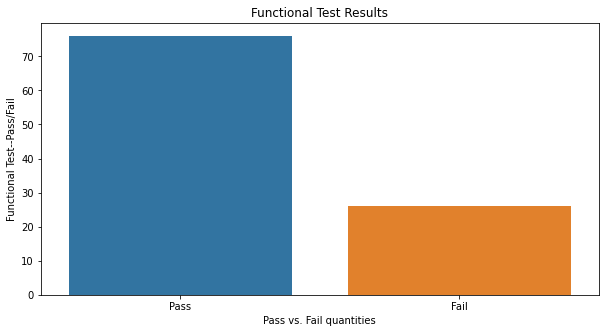

In [12]:
# Working with visualizations
byResult = df['FunctionalTest'].value_counts()
display(byResult)
#display(byResult)
plt.figure(figsize = (10, 5))
sns.barplot(x = byResult.index, y = byResult)
plt.title('Functional Test Results')
plt.xlabel('Pass vs. Fail quantities')
plt.ylabel('Functional Test--Pass/Fail');
#sns.barplot(y = 'FunctionalTest', data = df)

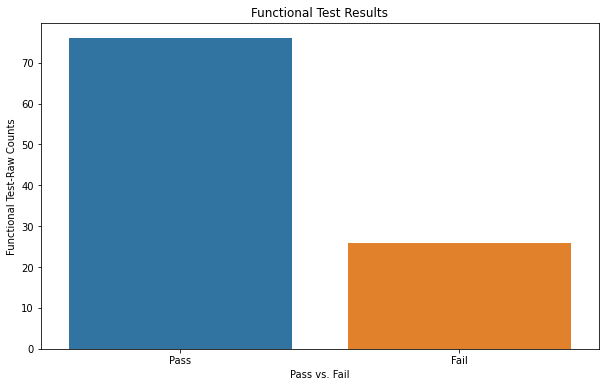

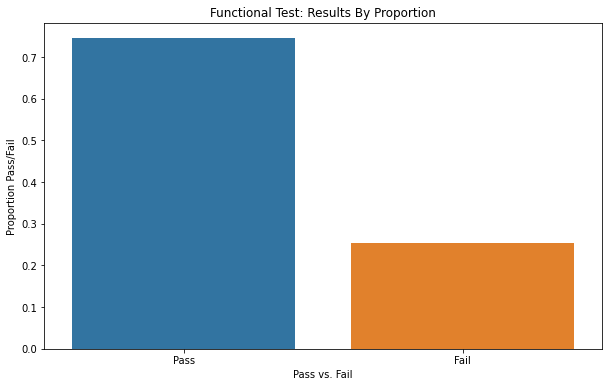

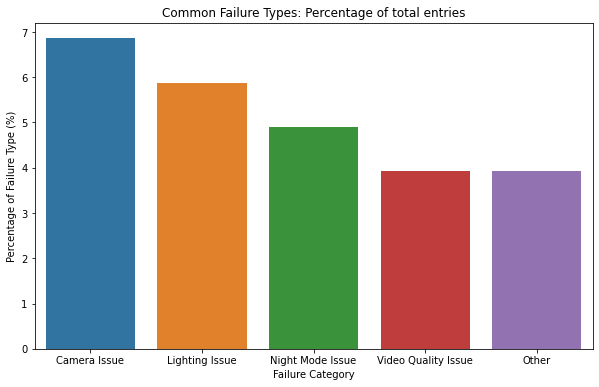

In [13]:
# Methods for trend visualization

# Raw counts for functional test results
def compareFunctionalTests(df):
    byResult = df['FunctionalTest'].value_counts()
    plt.figure(figsize = (10, 6))
    plot = sns.barplot(x = byResult.index, y = byResult)
    plot.set(xlabel = 'Pass vs. Fail', ylabel = 'Functional Test-Raw Counts', title = 'Functional Test Results')
    return plot

# Get the relative counts
def relativeFunctionalTests(df):
    relativeRates = df['FunctionalTest'].value_counts(normalize = True)
    plt.figure(figsize = (10, 6))
    plot = sns.barplot(x = relativeRates.index, y = relativeRates)
    plot.set(xlabel = 'Pass vs. Fail', ylabel = 'Proportion Pass/Fail', title = 'Functional Test: Results By Proportion')
    return plot

# Failure rates by catgory (% of ALL entries that fall under each bucket)
def failureVisual(df):
    origSize = len(df) # Get the number of total entries
    byFailure = df['FailureType'].value_counts(normalize = True) * 100 # Get percentage of failure rates
    byFailure = byFailure.drop(labels = ['None']) # Don't need to retain the non-failure options
    plt.figure(figsize = (10, 6))
    plot = sns.barplot(x = byFailure.index, y = byFailure)
    plot.set(xlabel = 'Failure Category', ylabel = 'Percentage of Failure Type (%)', title = 'Common Failure Types: Percentage of total entries')
    return plot


compareFunctionalTests(df);
plt.savefig('funcTests.png')
relativeFunctionalTests(df);
plt.savefig('funcTestsRelative.png')
failureVisual(df)
plt.savefig('failureType.png')

### Everything beneath is outdated

In [ ]:
# client = boto3.client('rds-data')
# response = client.execute_statement(
#     secretArn = secretARN,
#     database = dbName,
#     resourceArn = resourceARN,
#     sql = 'Show Tables'
# )
# display(response['records'])


In [ ]:
# # Helper method to execute a SQL query
# def execute(q):
#     response = client.execute_statement(
#         secretArn = secretARN,
#         database = dbName,
#         resourceArn = resourceARN,
#         sql = q
#     )
#     return response

# # Execute longer queries for select statements (need to go possibly to > 1MB)
# def executeBatch(q):
#     responses = []
#     qTemp = ''' Select Count(*) from QAResults '''
#     numEntries = execute(qTemp)['records'][0][0]['longValue']
#     limit = 1000
#     #print('numEntries:', numEntries)
#     for i in range(numEntries//limit + 1):
#         response = client.execute_statement(
#             secretArn = secretARN,
#             database = dbName,
#             resourceArn = resourceARN,
#             sql = q + ' Limit {} Offset {}'.format(limit, i * limit)
#         )
#         #print(response)
#         responses.append(response['records'])
#     return responses

# #deleteTable()

In [ ]:

# # Create the basic table
# def createTable():
#     q = '''
#         Create table if not exists QAResults(
#             SerialNumber VARCHAR(30),
#             BatchNumber VARCHAR(30),
#             Date VARCHAR(10),
#             Tester VARCHAR(30),
#             FunctionalTest VARCHAR(4),
#             LogMessage text,
#             primary key (SerialNumber)
#         )
#     '''
#     return execute(q)

# # Simple method to return date in YYYY-MM-DD format
# def getDate():
#     return dt.datetime.today().strftime('%Y-%m-%d') # YYYY-MM-DD

# # Fetch an entry based off of serial number
# def getEntry(sn):
#     try:
#         q = ''' SELECT * FROM QAResults where SerialNumber = '{}' '''.format(sn)
#         return execute(q)
#     except Exception as e:
#         print('Issue with get entry:', e)

# # Helper method to insert an entry
# # sn, bn, date, tester, ft, log
# def insertEntry(sn, bn, ft, tst, msg, date = getDate()):
#     try:
#         q = ''' Insert into QAResults values ('%s', '%s', '%s', '%s', '%s', '%s')''' % (sn, bn, date, tst, ft, msg)
#         return execute(q)
#     except Exception as e:
#         print('Issue with add entry:', e)

# # Delete an entry based on SN alone
# def deleteEntry(sn):
#     try:
#         q = ''' Delete from QAResults where SerialNumber = '%s' ''' % (sn)
#         return execute(q)
#     except Exception as e:
#         print('Issue with delete entry:', e)

# # Modify a field based off of SN
# def modifyEntry(sn, field, newVal):
#     try:
#         q = ''' Update QAResults set {} = '{}' where SerialNumber = '{}' '''.format(field, newVal,sn)
#         return execute(q)
#     except Exception as e:
#         print('Issue with edit entry:', e)

# # Get all the results for the table
# def displayAll():
#     try:
#         print('\n\nQAResults Table\n')
#         q = ''' Select * From QAResults '''
#         records = executeBatch(q)
#         entries = records[0]
#         for r in entries:
#             print('Entry:', r)
#     except Exception as e:
#         print('Issue with displaying table:', e)

# # Delete the entire table
# def deleteTable():
#     try:
#         q = 'Drop Table QAResults'
#         return execute(q)
#     except Exception as e:
#         print('Issue while deleting table:', e)


In [ ]:

# # Initial Testing the framework above
# createTable()
# #displayAll() # After initial table creation
# insertEntry('EEE833134W0', 'E2', 'Pass', 'Zach', 'Everything works')
# insertEntry('EEE833134W1', 'E2', 'Fail', 'Ruohan','Everything works')
# insertEntry('EEE833134W2', 'E2','Fail', 'Ryan','Breakdown occurred')
# displayAll() # After insertion of entries
# modifyEntry('EEE833134W1', 'BatchNumber', 'F33')
# displayAll() # After modification of an entry
# deleteEntry('EEE833134W2')
# displayAll() # After deletion of an entry

In [ ]:

# # Functions + Variables to mass insert entries (consistently) into the database
# snPrefix = ['EUHWQ3931-', 'ABC22', 'RRH43144', '283367144']
# batchNums = ['EE1', 'FF2', 'GG3']
# testers = ['Zach', 'Ryan', 'Ruohan', 'Nikki', 'Megan']
# results = ['Pass', 'Fail']
# dates = [getDate(), '2020-05-02', '2020-06-09', '2019-11-27', '2021-04-19', '2021-04-01']
# messages = ['Camera issue', 'Night mode issue', 'Other issue-unlisted']
# passMsg = 'Everything works'

# def massInsertEntry(n):
#     for i in range(n):
#         sn = snPrefix[i % 4] + str(i)
#         bn = batchNums[i % 3]
#         t = testers[i % 5]
#         res = results[int(i % 4 == 0)]
#         d = dates[i % 6]
#         msg = passMsg if res == 'Pass' else messages[i % 3]
#         insertEntry(sn, bn, res, t, msg, d)
# massInsertEntry(50)
# displayAll()